<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot, os

In [2]:
# Load Data
data_path = "../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

# load_variables = "v0_rxy v0_chi2 cosTheta v0_ks_mass v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y".split(" ")
load_variables = data_tree.keys()[:57]
load_variables.remove(b"npv")

df = data_tree.pandas.df(load_variables, entrystop = 10**6)

mass = df.v0_ks_mass

remove = ["v0_ks_mass", "eventCounter", "rapidity_la", "rapidity_lb", "v0_ks_massErr", "v0_la_massErr", \
        "v0_lb_mass", "rapidity_ks", "v0_la_mass", "v0_lb_massErr"]

df = df.drop(remove, axis = 'columns')


from sklearn.model_selection import train_test_split
df_train, df_test, mass_train, mass_test = train_test_split(df, mass, test_size = 0.2)



In [3]:
from lightgbm import LGBMClassifier
import shap
from py_files.functions import roc_curve_data, double_gauss_fit

params = list(df.columns)


# mass to pseudolabel


Completed fit with Chi2: 101.6, p-val: 0.211 and the total amount of signal 15917 +/- 207, background: 784084
<ArgsView of Minuit at 55b561791e60>
  498.1716090323159
  5.217209016815705
  15916.801134557143
  0.5660620795674328
  2.3744095497088065
  3.901681206020163e-06
  0.06313368777890607
  -16.02045545103347
  2939.171066468862


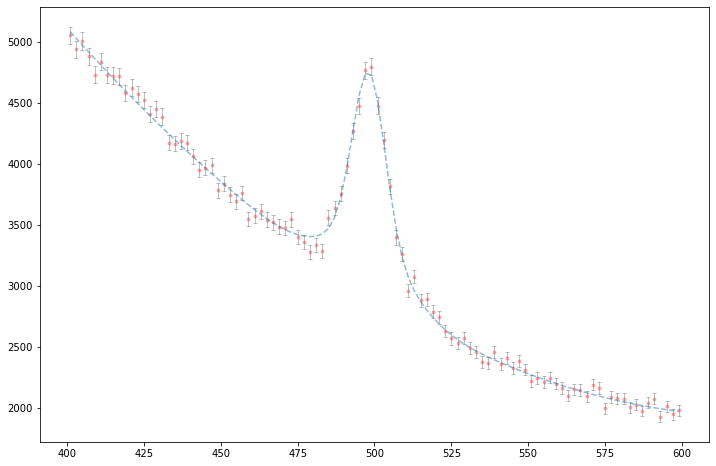

In [4]:
fig, ax = plt.subplots(figsize = (12, 8))

sig, back, err, args = double_gauss_fit(mass_train, ax = ax)

print(args)

In [5]:
# Apply range
mass_limits = mass_train[(mass_train > 400) & (mass_train < 600)]

# Take pseudo_true_sample
mean, sig = args[0], args[1]
pseudo_true = mass_limits[abs(mass_limits - mean) <  2 * sig]

am = len(pseudo_true)

# True false
low_false = mass_limits[(mass_limits  + 5 * sig < mean)| (mean > mass_limits + 10 * sig)].sample(am)
high_false = mass_limits[(mass_limits - 5 * sig > mean)| (mean < mass_limits - 10 * sig)].sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target.loc[pseudo_true.index] = True

In [6]:
model = LGBMClassifier()
model.fit(df_train.loc[indicies, params], target)

LGBMClassifier()

Completed fit with Chi2: 492.6, p-val: 0.000 and the total amount of signal 18261 +/- 138, background: 464
<ArgsView of Minuit at 55b561791e60>
  498.1716090323159
  5.217209016815705
  15916.801134557143
  0.5660620795674328
  2.3744095497088065
  3.901681206020163e-06
  0.06313368777890607
  -16.02045545103347
  2939.171066468862


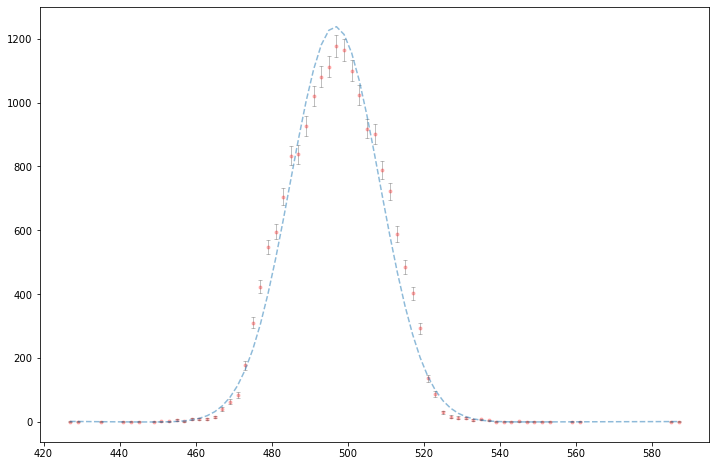

In [7]:
label = model.predict(df_test.loc[:, params])

fig, ax = plt.subplots(figsize = (12, 8))

sig, back, err, _ = double_gauss_fit(mass_test[label == 1], ax = ax)

print(args)

Completed fit with Chi2: 102.5, p-val: 0.193 and the total amount of signal 3721 +/- 127, background: 196279
Completed fit with Chi2: 102.4, p-val: 0.195 and the total amount of signal 3721 +/- 1862, background: 176279
Completed fit with Chi2: 105.0, p-val: 0.149 and the total amount of signal 3687 +/- 116, background: 156313
Completed fit with Chi2: 193.7, p-val: 0.000 and the total amount of signal 3721 +/- 10, background: 136279
Completed fit with Chi2: 172.9, p-val: 0.000 and the total amount of signal 3721 +/- 11, background: 116279
Completed fit with Chi2: 192.4, p-val: 0.000 and the total amount of signal 3721 +/- 12, background: 96279
Completed fit with Chi2: 447.1, p-val: 0.000 and the total amount of signal 3721 +/- 11, background: 76279
Completed fit with Chi2: 1445.2, p-val: 0.000 and the total amount of signal 3721 +/- 4, background: 56279
Completed fit with Chi2: 4217.0, p-val: 0.000 and the total amount of signal 3721 +/- 2, background: 36279
Completed fit with Chi2: 127

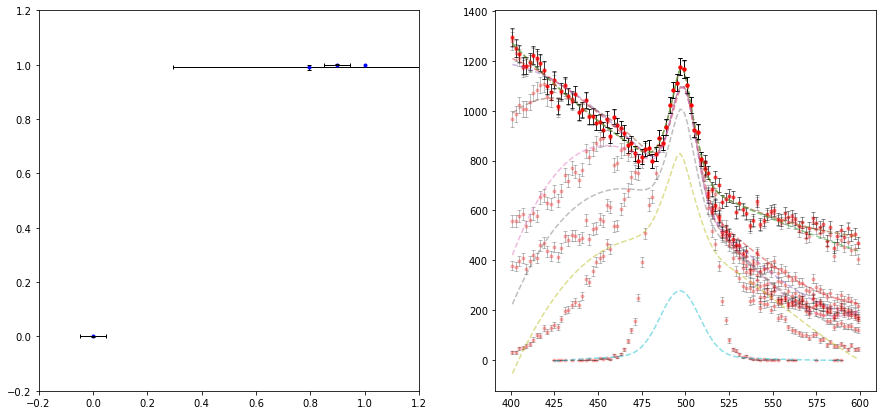

In [8]:
probs = model.predict_proba(df_test.loc[:, params])[:, 0]

fig, ax = plt.subplots(figsize = (15, 7), ncols = 2)
roc_curve_data(mass_test, 1- probs, ax_roc = ax[0], ax_fits = ax[1])

In [9]:
# most_corr = df_test.corrwith(mass_test).sort_values()[:8]
most_corr = ['epsilon1', 'v0_p2', 'v0_qOverP2', 'pL2', 'v0_p', 'calpha', 'v0_pz2', 'v0_pz',
 'pseudorapidity', 'v0_pz1', 'v0_theta1', 'v0_theta2', 'epsilon2', 'v0_ptErr',
 'v0_qOverP1', 'pL1', 'v0_p1', 'v0_pt1', 'alpha', 'Alpha', 'thetastar', 'pT', 'v0_rxy', 'v0_rxyErr'] + list(df_test.loc[:, params].corrwith(mass_test, method = 'kendall').sort_values()[:4].index)
print(most_corr)
drop_cols = most_corr
# drop_cols = list(most_corr.index)
for col in drop_cols:
    if col in params:
        params.remove(col)

['epsilon1', 'v0_p2', 'v0_qOverP2', 'pL2', 'v0_p', 'calpha', 'v0_pz2', 'v0_pz', 'pseudorapidity', 'v0_pz1', 'v0_theta1', 'v0_theta2', 'epsilon2', 'v0_ptErr', 'v0_qOverP1', 'pL1', 'v0_p1', 'v0_pt1', 'alpha', 'Alpha', 'thetastar', 'pT', 'v0_rxy', 'v0_rxyErr', 'calpha', 'v0_rxyErr', 'v0_rxy', 'v0_ptErr']


In [10]:
model = LGBMClassifier()
model.fit(df_train.loc[indicies, params], target)

LGBMClassifier()

Completed fit with Chi2: 102.5, p-val: 0.193 and the total amount of signal 3721 +/- 127, background: 196279
3721.4957179965845 196278.5042820034
Completed fit with Chi2: 98.8, p-val: 0.271 and the total amount of signal 4282 +/- 83, background: 3255
4281.755737491787 3254.244262508213


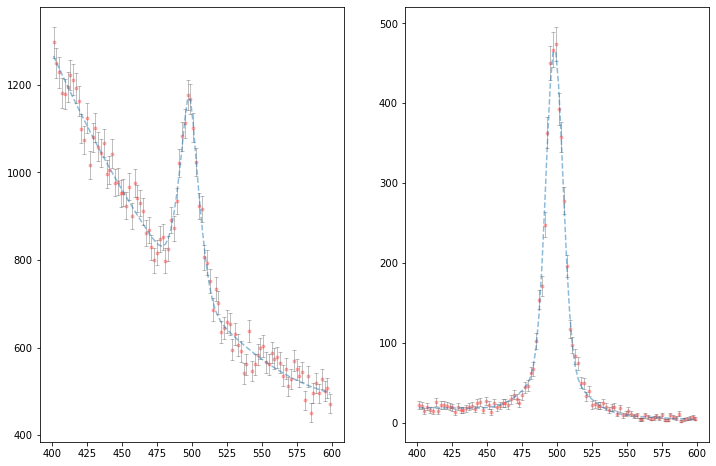

In [11]:
label = model.predict(df_test.loc[:, params])

fig, ax = plt.subplots(figsize = (12, 8), ncols = 2)

sig, back, err, _ = double_gauss_fit(mass_test, ax = ax[0])
print(sig, back)
sig, back, err, _ = double_gauss_fit(mass_test[label == 1], ax = ax[1])
print(sig, back)

# print(args)

Completed fit with Chi2: 102.5, p-val: 0.193 and the total amount of signal 3721 +/- 127, background: 196279
Completed fit with Chi2: 101.3, p-val: 0.215 and the total amount of signal 3663 +/- 150, background: 188338
Completed fit with Chi2: 101.6, p-val: 0.210 and the total amount of signal 3653 +/- 138, background: 180347
Completed fit with Chi2: 101.4, p-val: 0.215 and the total amount of signal 3608 +/- 114, background: 172393
Completed fit with Chi2: 103.6, p-val: 0.173 and the total amount of signal 3523 +/- 84, background: 164478
Completed fit with Chi2: 97.8, p-val: 0.295 and the total amount of signal 3460 +/- 140, background: 156541
Completed fit with Chi2: 105.2, p-val: 0.146 and the total amount of signal 3442 +/- 423, background: 148558
Completed fit with Chi2: 117.5, p-val: 0.032 and the total amount of signal 3468 +/- 160, background: 140532
Completed fit with Chi2: 119.0, p-val: 0.026 and the total amount of signal 3519 +/- 171, background: 132481
Completed fit with Ch

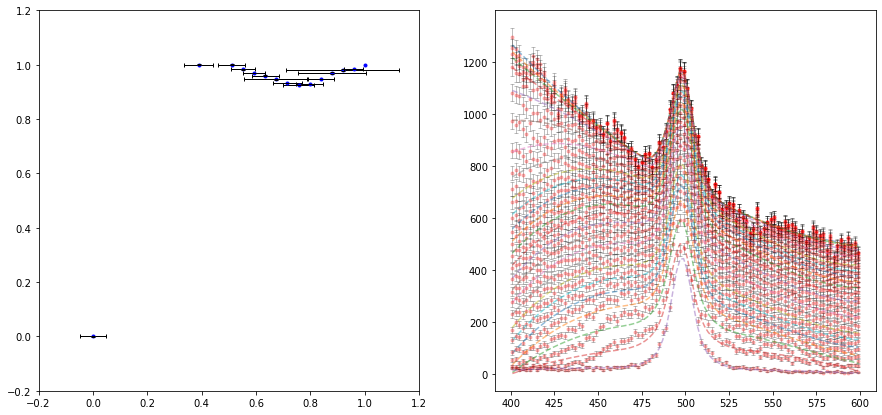

In [12]:
probs = model.predict_proba(df_test.loc[:, params])[:, 1]

fig, ax = plt.subplots(figsize = (15, 7), ncols = 2)
roc_curve_data(mass_test, probs, ax_roc = ax[0], ax_fits = ax[1], Npoints = 25)

In [15]:
sample = shap.sample(df_test.loc[:, params], 1000)
expl = shap.TreeExplainer(model, data = sample)

In [16]:
shap_values = expl.shap_values(sample)

100%|===================| 997/1000 [00:19<00:00]        

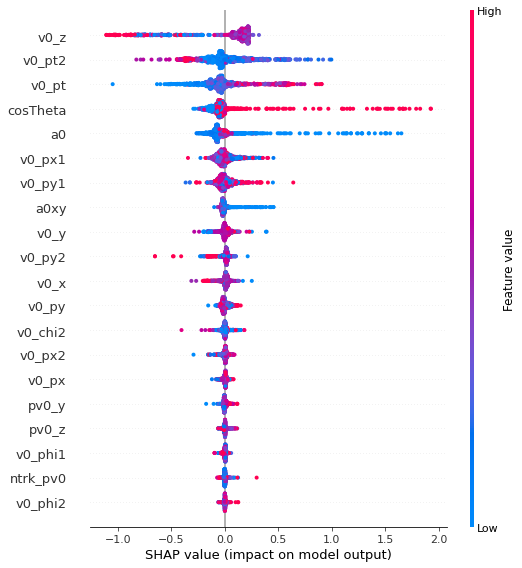

In [17]:
shap.summary_plot(shap_values, sample)

In [22]:
keep_feature_amount = len(params) - 3
decrements = 2


while len(params) > 2:
    model = LGBMClassifier()
    model.fit(df_train.loc[indicies, params], target)
    
    print(params)
    
    label = model.predict(df_test.loc[:, params])

    sig, back, err, _ = double_gauss_fit(mass_test, verbose = False)
    print(f"all data signal: {sig:.1f}")
    sig, back, err, _ = double_gauss_fit(mass_test[label == 1], verbose = False)
    print(f"classified signal: {sig:.1f}")
    
    test_set = df_test.loc[:, params]    
    
    probs = model.predict_proba(test_set)[:, 1]

    fig, ax = plt.subplots(figsize = (8, 4), ncols = 2)
    roc_curve_data(mass_test, probs, ax_roc = ax[0], ax_fits = ax[1], Npoints = 10, verbose = False)
    
    sample = shap.sample(df_train.loc[indicies, params], 1000)
    expl = shap.TreeExplainer(model, data = sample, check_additivity=False)
    
    shap_values = expl.shap_values(sample, check_additivity=False)
    
    features = test_set.columns[np.argsort(abs(shap_values).mean(0))][:keep_feature_amount]
    print("Throwing:", test_set.columns[np.argsort(abs(shap_values).mean(0))][:keep_feature_amount][keep_feautre_amount:])
    keep_feature_amount -= decrements
    params = list(features)
    fig.show()